# Andrew Huberman Word Cloud
## Intro
Ladies and gentlemen, allow me to introduce you to one of the most brilliant minds of our time - **Andrew Huberman**. With an impressive academic background in neuroscience and a passion for exploring the depths of the human brain, Huberman has become a leading figure in the field of neurobiology. He is a professor of neurobiology at Stanford University and director of the Huberman Lab, where he and his team conduct groundbreaking research on neural circuits and the mechanisms of perception, cognition, and behavior. 
As someone who is constantly on the lookout for inspiring and informative content, I can confidently say that Andrew Huberman's podcast is a true gem. His ability to distill complex concepts into accessible and practical advice is truly remarkable, and his insights into the workings of the human brain are nothing short of fascinating.

<img src="andrewhuberman.png" alt="Alternative text" width="250" height="150" />

In fact, I was so inspired by the content of his podcast that I decided to take things a step further and create a wordcloud based on the most frequently occurring words in his episodes. By scraping the transcripts of his episodes and analyzing the data, I was able to gain a deeper understanding of the key topics and themes that Huberman explores in his work.

The resulting wordcloud was a stunning visual representation of the ideas and concepts that Huberman is most passionate about, and it is a testament to the power of his message. Whether you are a neuroscience enthusiast, a student of the human mind, or simply someone who is interested in optimizing your mental performance, I highly recommend checking out <a href="https://hubermanlab.com/">Andrew Huberman's podcast</a> and experiencing the power of his words for yourself. 

## Let's get to work
### 1. Install required packages

In [1]:
!pip install -r requirements.txt

### 2.Import required packages

In [2]:
from bs4 import BeautifulSoup
from bs4.dammit import EncodingDetector
import requests

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re

import matplotlib.pyplot as plt 
from PIL import Image, ImageOps
from os import path, getcwd
import numpy as np

import io
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

from tqdm import tqdm

import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2 .Implement some util functions

In [3]:
def get_data(html):
    """
    Function to retrieve data from a web page 
    and return a BeautifulSoup object
    """

    # Use the requests library to get data from the specified URL 
    #(Setting verify=False is a common approach to ignore SSL certificate errors)
    resp = requests.get(html, verify=False)

    # Determine the encoding of the HTTP response and HTML content
    http_encoding = resp.encoding if 'charset' in resp.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(resp.content, is_html=True)
    encoding = html_encoding or http_encoding

    # Use BeautifulSoup to parse the HTML content and create a soup object
    soup = BeautifulSoup(resp.content, from_encoding=encoding)

    # Return the soup object
    return soup

In [4]:
def get_links(soup):
    """Function to extract links from a web page represented by a BeautifulSoup object"""

    # Initialize an empty list to store the links
    http_link_list = [] 

    # Iterate through all 'a' tags with an href attribute on the page
    for link in soup.find_all('a', href=True):

        # Check if the link does not start with a '/' character, indicating it is not a relative URL
        if link['href'][0] != '/': 

            # Append the link to the http_link_list after removing any surrounding quotes
            http_link_list.append(link['href'].strip("'"))

    # Return the list of links
    return http_link_list

In [5]:
def get_text(text_array):
    """ get text from an array"""
    text = " ".join(text_array)
    return text

In [18]:
def get_transcripts(base_url,episode_list):
    """Get text from all episodes in list"""
    text_return = []
    pbar = tqdm(episode_list)
    for _ , episode_url in enumerate(pbar):
        url = base_url+"/"+episode_url
        text_return.append(get_transcript(url))
        pbar.set_description("getting transcript from {link}".format(link = url))
    return text_return

In [19]:
def get_transcript(url):
    """
    Function to extract text from a PDF file at a given URL, remove a specific sequence,
    and return the remaining text as a string
    """

    try:
        # Fetch the PDF file from the URL
        response = requests.get(url, stream=True)

        # Create a memory stream object for the PDF content
        pdf_stream = io.BytesIO(response.content)

        # Create a PDF resource manager object and set the caching to False
        resource_manager = PDFResourceManager(caching=False)

        # Create a buffer for the extracted text
        output_text = io.StringIO()

        # Create a PDF layout parameters object
        layout_params = LAParams()

        # Create a PDF page interpreter object
        page_interpreter = PDFPageInterpreter(
            resource_manager,
            TextConverter(resource_manager, output_text, laparams=layout_params)
        )

        # Loop through each page in the PDF document and extract text
        for page in PDFPage.get_pages(pdf_stream):
            # Process the page using the page interpreter
            page_interpreter.process_page(page)

        # Get the extracted text as a string
        extracted_text = output_text.getvalue()

        # Define start and end patterns for the sequence to be removed
        start_pattern = r"For recommended water filters, tests and the full show notes, please visit"
        end_pattern = r"Disclaimer: https://hubermanlab.com/disclaimer"

        # Combine the patterns to form a regex pattern for the entire sequence
        sequence_pattern = f"{start_pattern}.*{end_pattern}"

        # Use regex to find and remove the sequence from the extracted text
        extracted_text = re.sub(sequence_pattern, "", extracted_text, flags=re.DOTALL)

        # Return the extracted text as a string
        return extracted_text
    
    except:
        # Return an empty string in case of any error
        return ''

In [20]:
def punctuation_stop(text):
    """remove punctuation and stop words"""
    filtered = []
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered

In [21]:
def make_silhouette(input_path, output_path):
    """Converts a portrait image to a silhouette"""
    # Open input image and convert to grayscale
    with Image.open(input_path) as img:
        img = img.convert('L')

        # Invert image (black becomes white, white becomes black)
        img = ImageOps.invert(img)

        # Apply a threshold to turn all gray pixels to black
        threshold = 255
        img = img.point(lambda x: 0 if x < threshold else 255)

        # Convert image to RGBA and set alpha channel to 0 (transparent)
        img = img.convert('RGBA')
        data = img.getdata()
        new_data = []
        for item in data:
            if item[0] == 0 and item[1] == 0 and item[2] == 0:
                new_data.append((0, 0, 0, 255))
            else:
                new_data.append((255, 255, 255, 0))
        img.putdata(new_data)

        # Save output image
        img.save(output_path)

In [22]:
def get_random_elements(lst, n):
    """
    Function to get n random elements from a list and return them in a list
    """
    if n > len(lst):
        n = len(lst)
    
    return random.sample(lst, n)

### 3. Getting the text

In [23]:
#webpage 
base_url = 'https://readthatpodcast.com'

#gets word soup from website 
soupout = get_data(base_url)

#gets links from website     
h_links = get_links(soupout)

#remove the irrelevant links
h_links = h_links[12::]

"""
optional
you can uncomment the following lines of code to work with a subset of links to make the process faster
"""
# n = 10
# h_links = get_random_elements(h_links, n)

#return list of all episode text 
text_return_list = get_transcripts(base_url,h_links)
all_text = get_text(text_return_list)



C:\Users\ahmed\anaconda3\envs\wordcloud\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'readthatpodcast.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
getting transcript from https://readthatpodcast.com/resources/04%20Find%20Your%20Temperature%20Minimum%20to%20Defeat%20Jetlag%20Shift%20Work%20&%20Sleeplessness%20Huberman%20Lab%20Podcast%204.pdf: 100%|██████████| 10/10 [01:16<00:00,  7.64s/it]  


### 4. Clean the text

In [36]:
#removed punctuation and stop words 
filteredlst = punctuation_stop(all_text)

#list of unwanted words (based on trial and error)
unwanted = ['um','little','bit','within','without','with','might','two','one','yes','yeah','andrew''huberman','podcast','guest','guy','really','me','you','us','talk','little bit','thing','say','go','actually','even','probably','going','said','something','okay','maybe','got','well','way']

#remove unwanted words 
text = " ".join([ele for ele in filteredlst if ele not in unwanted])

### 5. Create the silhouette 

In [37]:
d = getcwd()
make_silhouette("andrewhuberman.png", "andrewhuberman_silouhette.png")

### 5. Create WordCloud Image 

In [38]:
#numpy image file of mask image 
mask_logo = np.array(Image.open(path.join(d, "andrewhuberman_silouhette.png")))

In [39]:
#create the word cloud object 
wc= WordCloud(background_color="white", max_words=5000, max_font_size=90, random_state=1, mask=mask_logo, stopwords=STOPWORDS)
wc.generate(text)

In [40]:
image_colors = ImageColorGenerator(mask_logo)

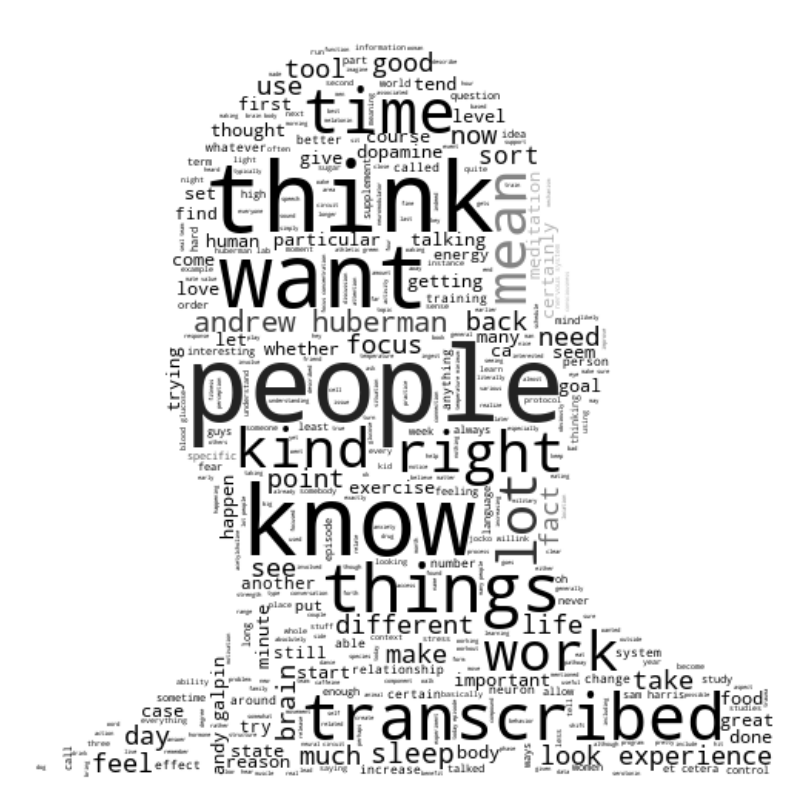

In [41]:
# plot the wordcloud silhouette
plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.show()

## Conclusion
I encourage everyone to take a closer look at the obtained word cloud and try to interpret it for themselves. What themes and ideas do you see emerging from the most frequently occurring words? How do these words relate to one another, and what insights can you gain from the appearance of such word so frequently in andrew's podcasts ?